### Loading Packages and Data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [5]:
ls /mnt/team/simulation_science/costeffectiveness/results/vivarium_nih_us_cvd/model_13_updated_ldl_ladder/alabama/2023_03_30_15_01_51/count_data

deaths.csv                       sbp_medication_person_time.csv
deaths.hdf                       sbp_medication_person_time.hdf
healthcare_visits.csv            state_person_time.csv
healthcare_visits.hdf            state_person_time.hdf
intervention_person_time.csv     transition_count.csv
intervention_person_time.hdf     transition_count.hdf
ldlc_medication_person_time.csv  ylds.csv
ldlc_medication_person_time.hdf  ylds.hdf
risk_exposure_time.csv           ylls.csv
risk_exposure_time.hdf           ylls.hdf


In [6]:
sim_results_dir = '/mnt/team/simulation_science/costeffectiveness/results/vivarium_nih_us_cvd/model_13_updated_ldl_ladder/alabama/2023_03_30_15_01_51/count_data'

## Checking Stability of Risks over Time

In [7]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw']).ptvalue.sum().reset_index()
per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,27454.412047
1,25_to_29,female,2023,232,27808.427105
2,25_to_29,female,2023,357,27639.315537
3,25_to_29,female,2023,394,27482.239562
4,25_to_29,female,2023,602,27422.291581


In [8]:
%%capture
for sex in per_time_group.sex.unique():
    for age in per_time_group.age.unique():
        plt.figure() 
        subdata = per_time_group.loc[(per_time_group.sex==sex) & (per_time_group.age==age)]
        plt.plot(subdata['year'], subdata['ptvalue'], marker='o')
        #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Person Time: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.ylim(0,300000)
        plt.grid()

### BMI

In [9]:
risk_exp = pd.read_csv(sim_results_dir + '/risk_exposure_time.csv')
risk_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,25_to_29,851128.661230
1,1,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,30_to_34,867762.873934
2,2,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,35_to_39,830115.527357
3,3,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,40_to_44,805116.860828
4,4,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,45_to_49,814359.267459


In [10]:
bmi_exp = risk_exp.loc[risk_exp['risk']=='high_body_mass_index_in_adults']
bmi_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
0,0,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,25_to_29,851128.661230
1,1,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,30_to_34,867762.873934
2,2,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,35_to_39,830115.527357
3,3,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,40_to_44,805116.860828
4,4,female,2023,high_body_mass_index_in_adults,risk_exposure_time,29,baseline,45_to_49,814359.267459


In [11]:
bmi_exp_summ = (bmi_exp
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
bmi_exp_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,846283.281631,841632.048266,853710.373704
1,25_to_29,female,2024,837645.010999,832429.533699,846965.445559
2,25_to_29,female,2025,829980.259307,824313.345294,839068.088211
3,25_to_29,female,2026,825392.720129,819171.428897,835024.411936
4,25_to_29,female,2027,822801.213652,815786.665689,830203.684570


In [12]:
%%capture
for sex in bmi_exp_summ.sex.unique():
    for age in bmi_exp_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_summ.loc[(bmi_exp_summ.sex==sex) & (bmi_exp_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

In [13]:
bmi_exp_rate = bmi_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
bmi_exp_rate = pd.concat([bmi_exp_rate, per_time_group.ptvalue], axis=1)
bmi_exp_rate['bmi_rate'] = bmi_exp_rate['value'] / bmi_exp_rate['ptvalue']
bmi_exp_rate_summ = (bmi_exp_rate
                .groupby(['age', 'sex', 'year'])
                .bmi_rate.describe(percentiles=[.025,0.5, .975])
                .filter(['mean', '50%','2.5%', '97.5%'])
                .reset_index())
bmi_exp_rate_summ.head()

,age,sex,year,mean,50%,2.5%,97.5%
0,25_to_29,female,2023,30.712442,30.660227,30.393726,30.987004
1,25_to_29,female,2024,30.719274,30.677860,30.395679,30.992008
2,25_to_29,female,2025,30.718672,30.703455,30.389142,30.982078
3,25_to_29,female,2026,30.711903,30.715058,30.409427,30.968575
4,25_to_29,female,2027,30.709516,30.708931,30.437853,30.977293


In [14]:
%%capture
for sex in bmi_exp_rate_summ.sex.unique():
    for age in bmi_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.ylim(20,33)
        plt.grid()

Older people are getting lower BMI's overtime - that is bad 

### SBP 

In [15]:
risk_exp['risk'].unique()

array(['high_body_mass_index_in_adults', 'high_fasting_plasma_glucose',
       'high_ldl_cholesterol', 'high_systolic_blood_pressure'],
      dtype=object)

In [16]:
sbp_exp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp_exp_rate = sbp_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
sbp_exp_rate = pd.concat([sbp_exp_rate, per_time_group.ptvalue], axis=1)
sbp_exp_rate['sbp_rate'] = sbp_exp_rate['value'] / sbp_exp_rate['ptvalue']
sbp_exp_rate_summ = (sbp_exp_rate
                .groupby(['age', 'sex', 'year'])
                .sbp_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
sbp_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,109.992128,107.857334,112.521967
1,25_to_29,female,2024,109.965883,107.792939,112.511199
2,25_to_29,female,2025,109.942845,107.773862,112.469678
3,25_to_29,female,2026,109.938661,107.782611,112.459150
4,25_to_29,female,2027,109.947457,107.810853,112.477677


In [17]:
%%capture
for sex in sbp_exp_rate_summ.sex.unique():
    for age in sbp_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

This one is decreasing over time as well... 

### LDL-C

In [18]:
ldl_exp = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl_exp_rate = ldl_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_exp_rate = pd.concat([ldl_exp_rate, per_time_group.ptvalue], axis=1)
ldl_exp_rate['ldl_rate'] = ldl_exp_rate['value'] / ldl_exp_rate['ptvalue']
ldl_exp_rate_summ = (ldl_exp_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,2.633385,2.560000,2.797350
1,25_to_29,female,2024,2.632794,2.556675,2.800343
2,25_to_29,female,2025,2.631287,2.553999,2.798520
3,25_to_29,female,2026,2.631961,2.553388,2.802003
4,25_to_29,female,2027,2.632648,2.554620,2.805235


In [19]:
%%capture
for sex in ldl_exp_rate_summ.sex.unique():
    for age in ldl_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL-C Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

LDL-C increases in some age groups but decreases in the oldest age groups 

### FPG

In [20]:
fpg_exp = risk_exp.loc[risk_exp['risk']=='high_fasting_plasma_glucose']
fpg_exp_rate = fpg_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
fpg_exp_rate = pd.concat([fpg_exp_rate, per_time_group.ptvalue], axis=1)
fpg_exp_rate['fpg_rate'] = fpg_exp_rate['value'] / fpg_exp_rate['ptvalue']
fpg_exp_rate_summ = (fpg_exp_rate
                .groupby(['age', 'sex', 'year'])
                .fpg_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
fpg_exp_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,5.340858,4.837370,6.192665
1,25_to_29,female,2024,5.338820,4.833888,6.192614
2,25_to_29,female,2025,5.338258,4.835010,6.189682
3,25_to_29,female,2026,5.337458,4.838437,6.185765
4,25_to_29,female,2027,5.337502,4.837995,6.182510


In [21]:
%%capture
for sex in fpg_exp_rate_summ.sex.unique():
    for age in fpg_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'FPG Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

Even more interestingly, this one looks good and very stable over time 

## Comparison to Artifacts

In [22]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/

alabama.hdf  raw_data/  washington.hdf


In [23]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [24]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [25]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.myocardial_infarction.incidence_rate',
 'cause.acute_myocardial_infarction.disability_weight',
 'cause.post_myocardial_infarction.disability_weight',
 'cause.acute_myocardial_infarctio

In [30]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### BMI

In [31]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
bmi_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,30.865099,30.817930,30.517198,31.247504,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,31.607178,31.645317,31.349718,31.799262,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,31.826059,31.814623,31.613541,32.037692,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,32.237747,32.229013,32.032432,32.462008,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,32.094423,32.126050,31.895619,32.243715,Alabama,exposure,45_to_49


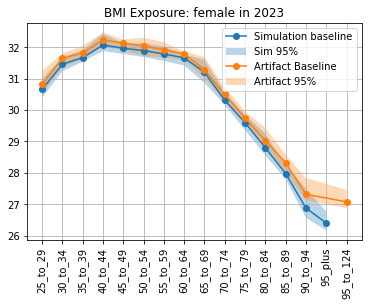

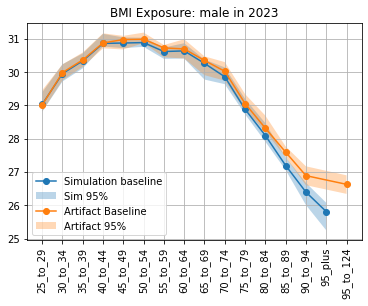

In [32]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

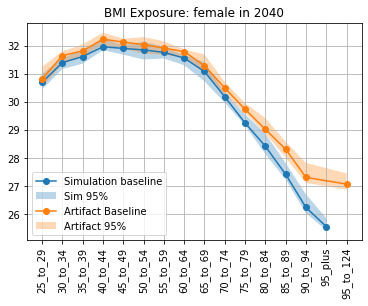

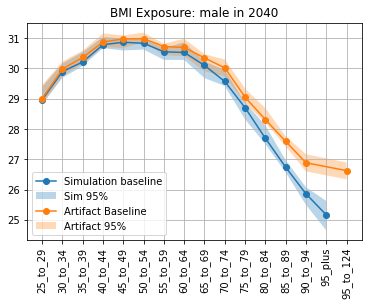

In [33]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### SBP

In [27]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,110.635893,107.945700,113.550750,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,112.876275,110.098198,115.523727,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,116.139886,113.594023,118.770064,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,118.491616,115.903577,121.039457,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,121.645391,118.875235,124.529834,Alabama,exposure,45_to_49


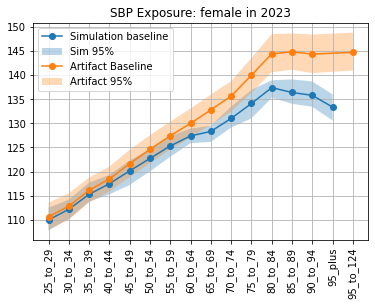

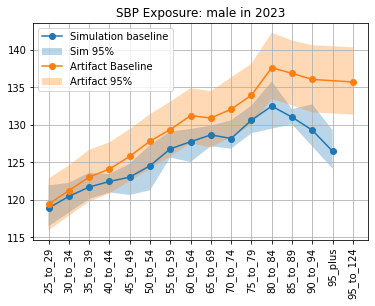

In [28]:
#Can we stratify by medication coverage? 

for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

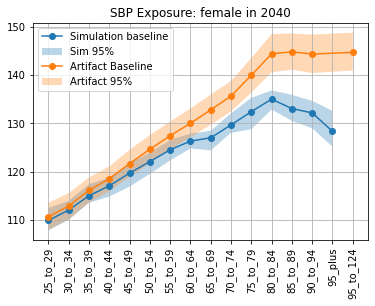

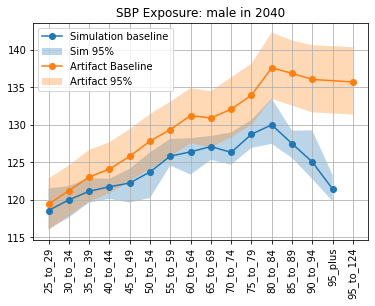

In [29]:
for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### LDL-C

In [117]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,2.639862,2.472574,2.821188,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,2.724353,2.553736,2.905134,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,2.802925,2.639513,2.972487,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,2.880791,2.721814,3.039119,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,2.998297,2.837974,3.175367,Alabama,exposure,45_to_49


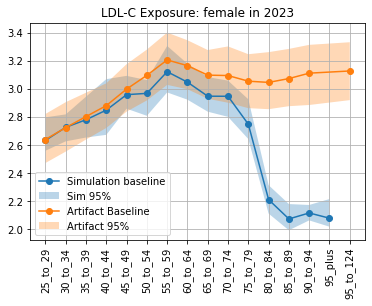

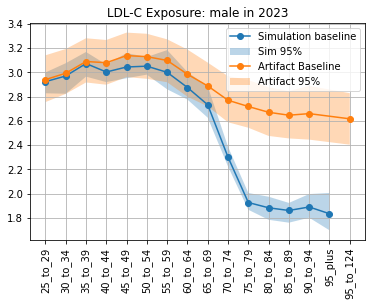

In [118]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

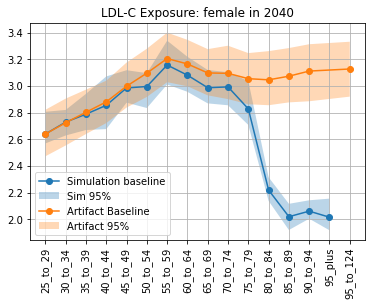

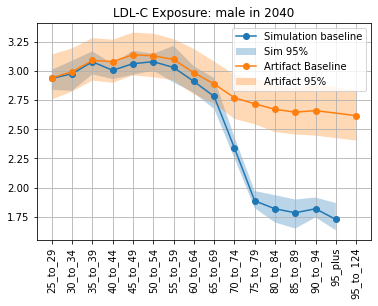

In [119]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### FPG

In [33]:
fpg_art = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure')
fpg_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_art.age_start,fpg_art.age_end)]
fpg_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,continuous,5.316303,4.613215,6.137399,Alabama,exposure,25_to_29
1,female,30.0,35.0,2019,2020,continuous,5.461718,4.696085,6.297658,Alabama,exposure,30_to_34
2,female,35.0,40.0,2019,2020,continuous,5.538952,4.750516,6.371252,Alabama,exposure,35_to_39
3,female,40.0,45.0,2019,2020,continuous,5.659873,4.873814,6.494619,Alabama,exposure,40_to_44
4,female,45.0,50.0,2019,2020,continuous,5.787248,5.004493,6.682187,Alabama,exposure,45_to_49


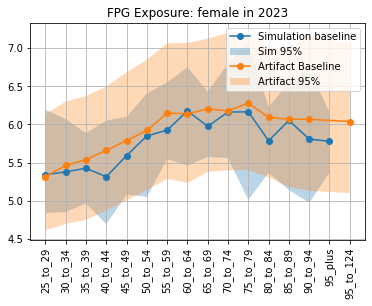

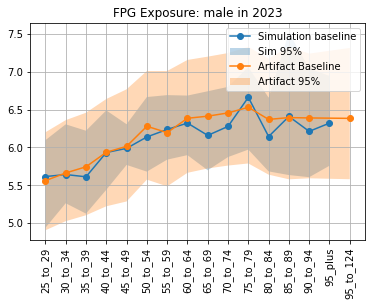

In [34]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

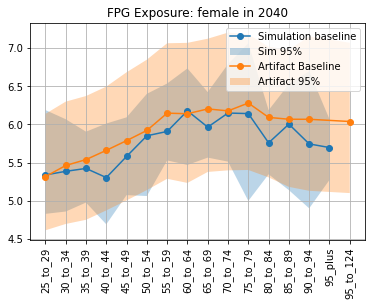

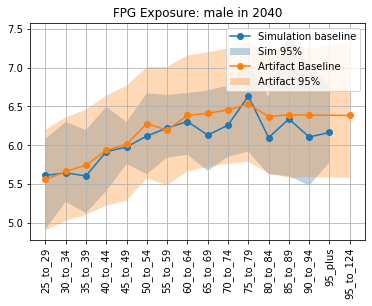

In [35]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Very interestingly (and almost worse overall) FPG is working great while the other 3 are looking bad

# SBP Medications

In [86]:
meds = pd.read_csv(sim_results_dir + 'sbp_medication_person_time.csv')
meds.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,medication_adherence,sbp_medication,value
0,0,female,2023,sbp_medication_person_time,29,baseline,25_to_29,primary_non_adherent,no_treatment,4106.666667
1,1,female,2023,sbp_medication_person_time,29,baseline,25_to_29,secondary_non_adherent,no_treatment,2538.436687
2,2,female,2023,sbp_medication_person_time,29,baseline,25_to_29,adherent,no_treatment,18211.077344
3,3,female,2023,sbp_medication_person_time,29,baseline,30_to_34,primary_non_adherent,no_treatment,3599.408624
4,4,female,2023,sbp_medication_person_time,29,baseline,30_to_34,secondary_non_adherent,no_treatment,2403.208761


In [121]:
meds_adherent = meds.loc[meds['medication_adherence']=='adherent'].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['age', 'sex', 'year', 'sbp_medication'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ

,age,sex,year,sbp_medication,mean,2.5%,97.5%
0,25_to_29,female,2023,no_treatment,0.659124,0.644015,0.665614
1,25_to_29,female,2023,one_drug_half_dose_efficacy,0.053759,0.045464,0.064745
2,25_to_29,female,2023,one_drug_std_dose_efficacy,0.001218,0.000901,0.001495
3,25_to_29,female,2023,three_drug_half_dose_efficacy,0.000578,0.000364,0.000937
...,...,...,...,...,...,...,...
3776,95_plus,male,2040,three_drug_half_dose_efficacy,0.043333,0.030277,0.058251
3777,95_plus,male,2040,three_drug_std_dose_efficacy,0.156070,0.126394,0.195724
3778,95_plus,male,2040,two_drug_half_dose_efficacy,0.116325,0.081569,0.148214
3779,95_plus,male,2040,two_drug_std_dose_efficacy,0.039520,0.031013,0.049915


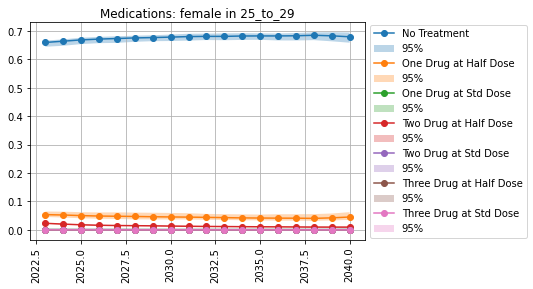

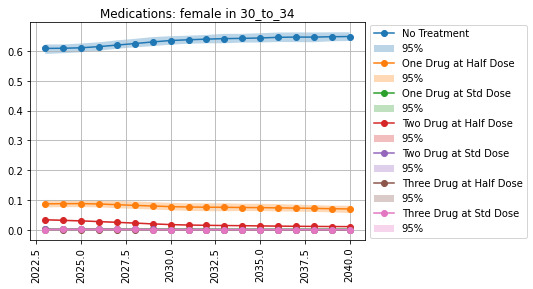

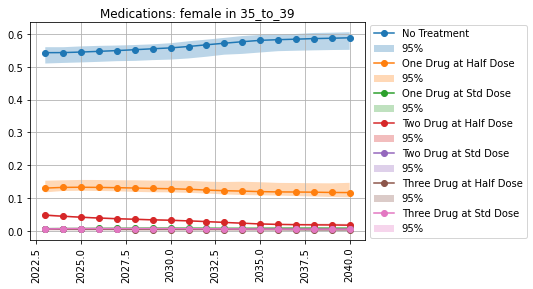

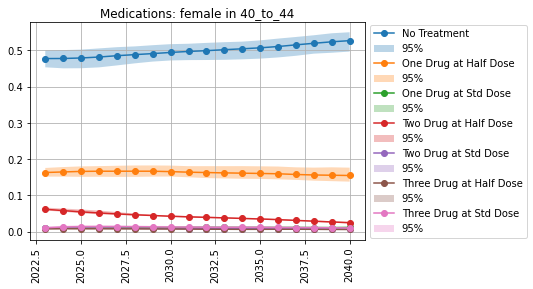

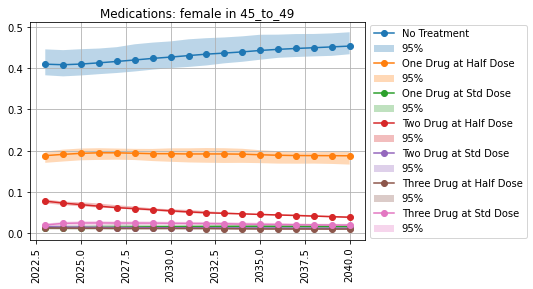

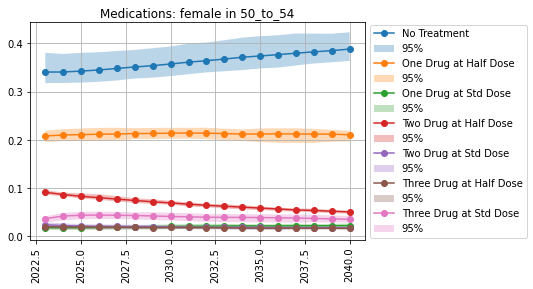

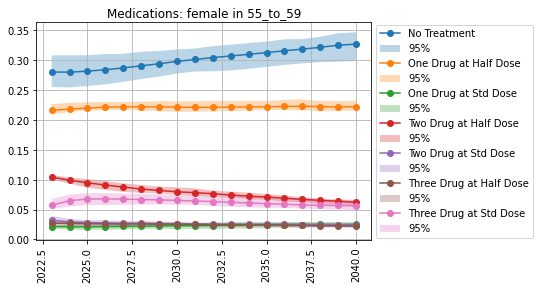

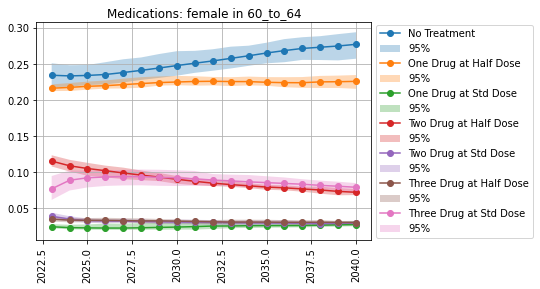

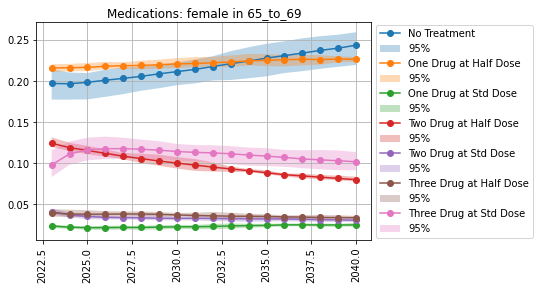

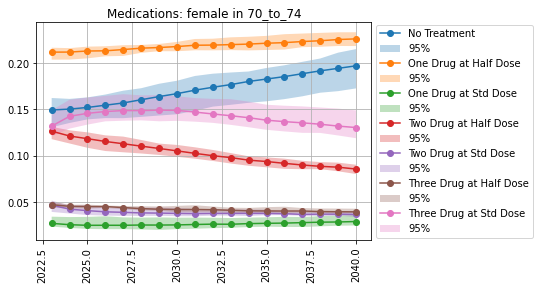

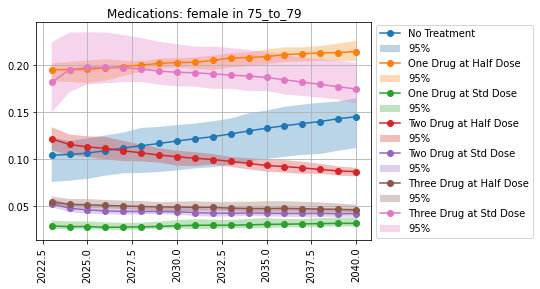

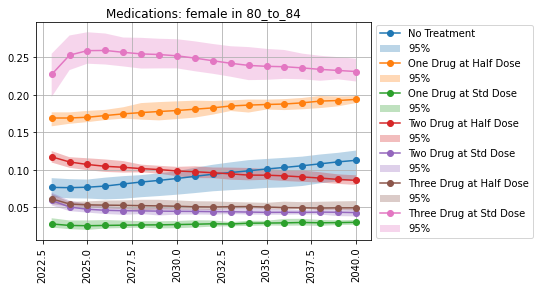

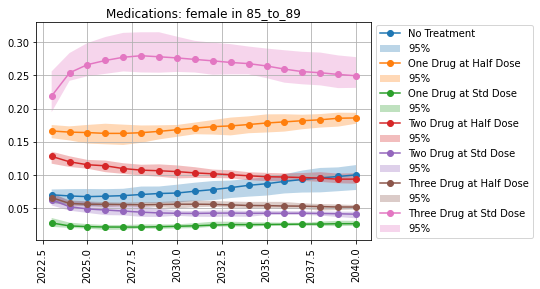

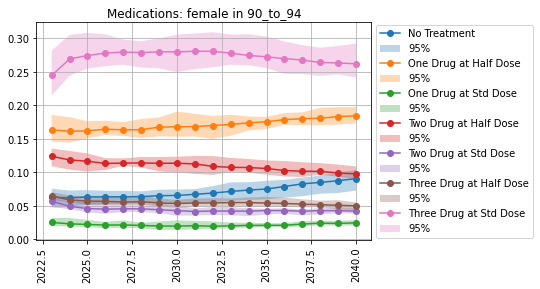

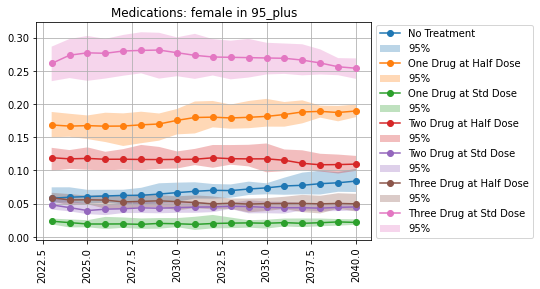

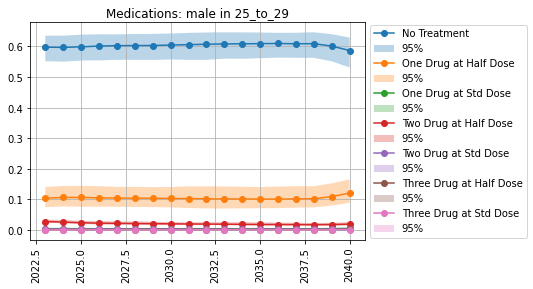

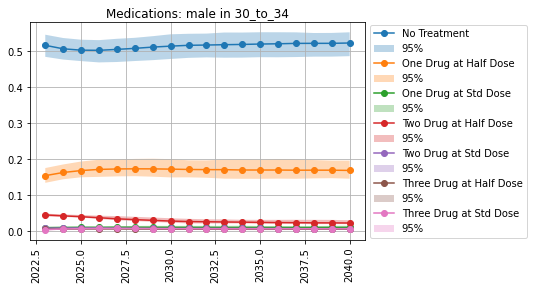

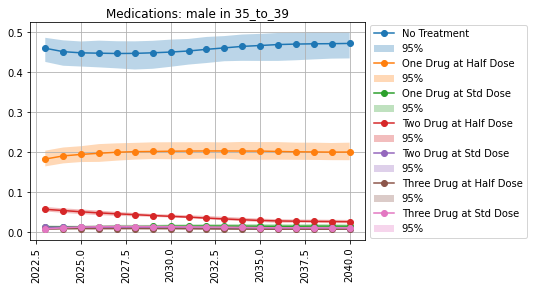

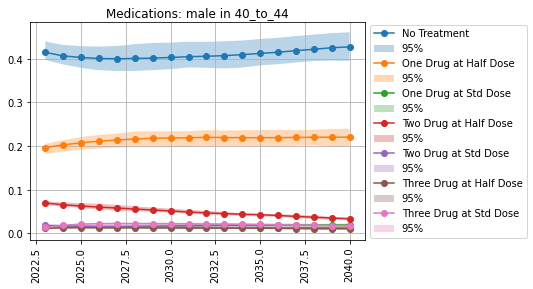

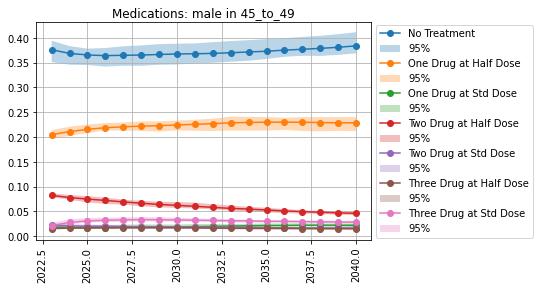

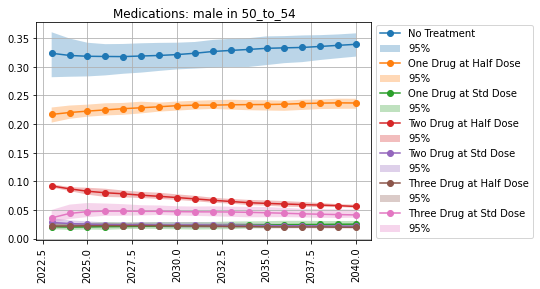

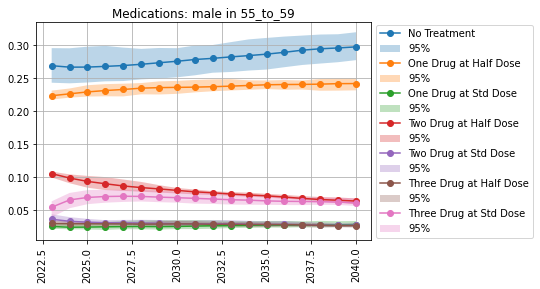

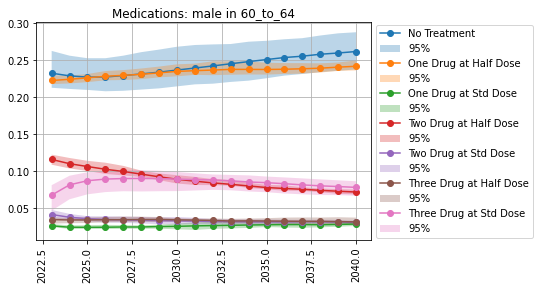

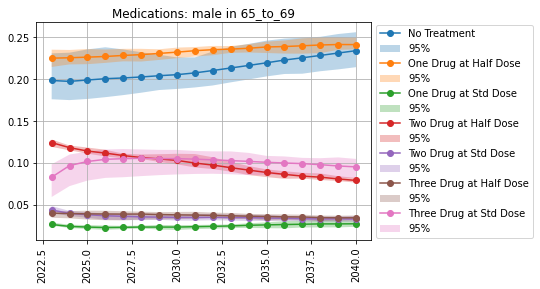

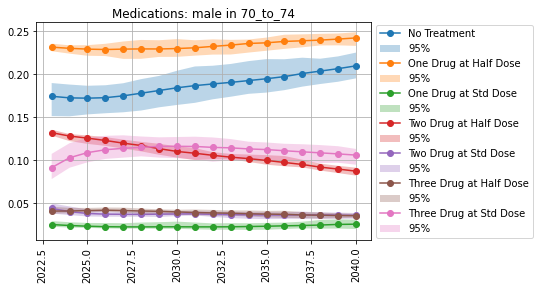

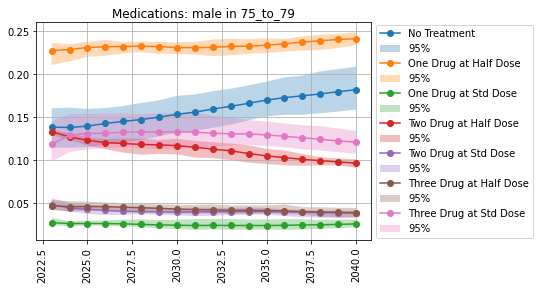

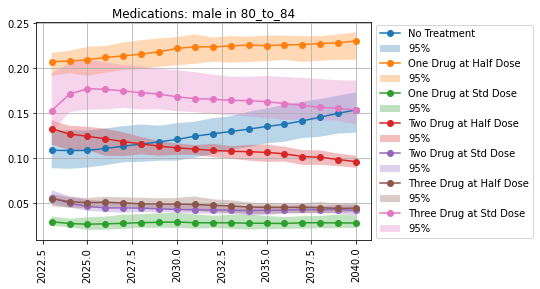

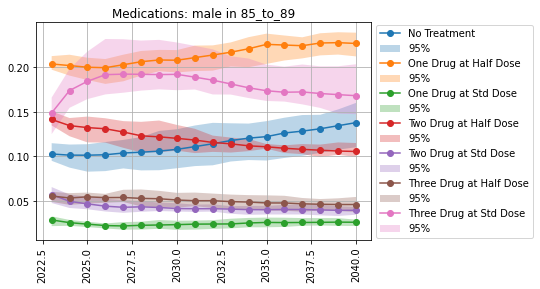

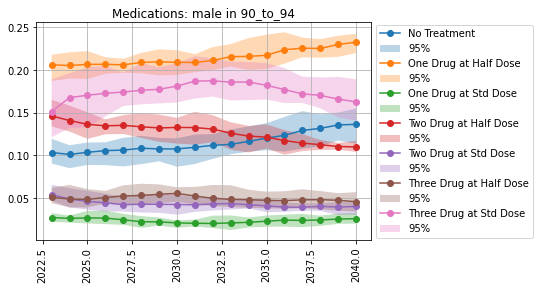

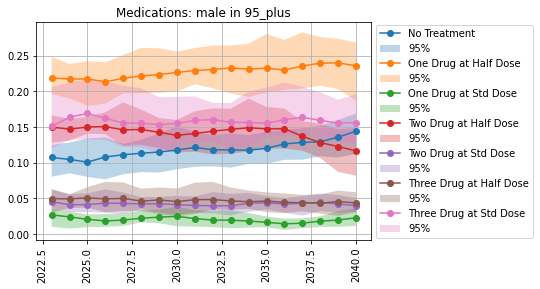

In [122]:
#%%capture
for sex in meds_adherent_rate_summ.sex.unique():
    for age in meds_adherent_rate_summ.age.unique():
        plt.figure() 
        no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='no_treatment')]
        plt.plot(no_trt['year'], no_trt['mean'], marker='o')
        plt.fill_between(no_trt['year'], no_trt['2.5%'], no_trt['97.5%'], alpha=.3)
        one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='one_drug_half_dose_efficacy')]
        plt.plot(one_half['year'], one_half['mean'], marker='o')
        plt.fill_between(one_half['year'], one_half['2.5%'], one_half['97.5%'], alpha=.3)
        one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='one_drug_std_dose_efficacy')]
        plt.plot(one_std['year'], one_std['mean'], marker='o')
        plt.fill_between(one_std['year'], one_std['2.5%'], one_std['97.5%'], alpha=.3)
        two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='two_drug_half_dose_efficacy')]
        plt.plot(two_half['year'], two_half['mean'], marker='o')
        plt.fill_between(two_half['year'], two_half['2.5%'], two_half['97.5%'], alpha=.3)
        two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='two_drug_std_dose_efficacy')]
        plt.plot(two_std['year'], two_std['mean'], marker='o')
        plt.fill_between(two_std['year'], two_std['2.5%'], two_std['97.5%'], alpha=.3)
        three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='three_drug_half_dose_efficacy')]
        plt.plot(three_half['year'], three_half['mean'], marker='o')
        plt.fill_between(three_half['year'], three_half['2.5%'], three_half['97.5%'], alpha=.3)
        three_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sbp_medication=='three_drug_std_dose_efficacy')]
        plt.plot(three_std['year'], three_std['mean'], marker='o')
        plt.fill_between(three_std['year'], three_std['2.5%'], three_std['97.5%'], alpha=.3)
        plt.title(f'Medications: {sex} in {age}') 
        plt.xticks(rotation=90)
        plt.legend(['No Treatment', '95%', 'One Drug at Half Dose', '95%', 'One Drug at Std Dose','95%','Two Drug at Half Dose', '95%','Two Drug at Std Dose', '95%','Three Drug at Half Dose', '95%','Three Drug at Std Dose', '95%'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()

In [99]:
ldl_meds = pd.read_csv(sim_results_dir + '/ldlc_medication_person_time.csv')
ldl_meds.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,medication_adherence,ldlc_medication,value
0,0,female,2023,ldlc_medication_person_time,29,baseline,25_to_29,primary_non_adherent,high_intensity,0.000000
1,1,female,2023,ldlc_medication_person_time,29,baseline,25_to_29,secondary_non_adherent,high_intensity,0.000000
2,2,female,2023,ldlc_medication_person_time,29,baseline,25_to_29,adherent,high_intensity,216.487337
3,3,female,2023,ldlc_medication_person_time,29,baseline,30_to_34,primary_non_adherent,high_intensity,0.000000
4,4,female,2023,ldlc_medication_person_time,29,baseline,30_to_34,secondary_non_adherent,high_intensity,0.000000


In [100]:
meds_adherent = ldl_meds.loc[ldl_meds['medication_adherence']=='adherent'].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['age', 'sex', 'year', 'ldlc_medication'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ

,age,sex,year,ldlc_medication,mean,2.5%,97.5%
0,25_to_29,female,2023,high_intensity,0.008614,0.007901,0.009229
1,25_to_29,female,2023,high_with_eze,0.000000,0.000000,0.000000
2,25_to_29,female,2023,low_intensity,0.001275,0.001048,0.001540
3,25_to_29,female,2023,low_med_with_eze,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
3236,95_plus,male,2040,low_intensity,0.008196,0.003497,0.012474
3237,95_plus,male,2040,low_med_with_eze,0.097148,0.077447,0.113406
3238,95_plus,male,2040,medium_intensity,0.140103,0.100590,0.179378
3239,95_plus,male,2040,no_treatment,0.024912,0.015630,0.034890


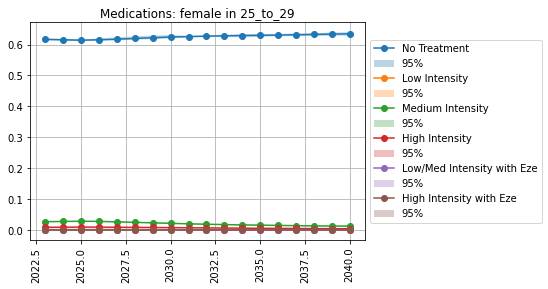

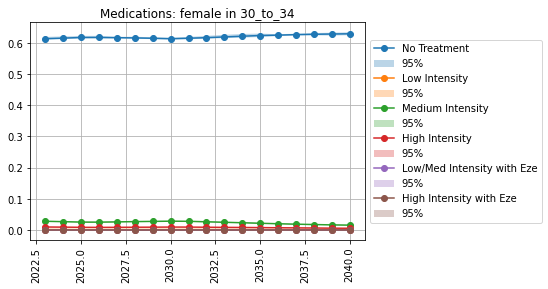

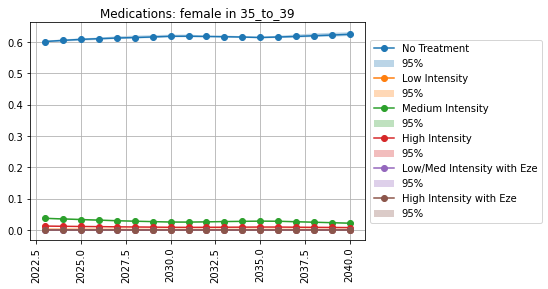

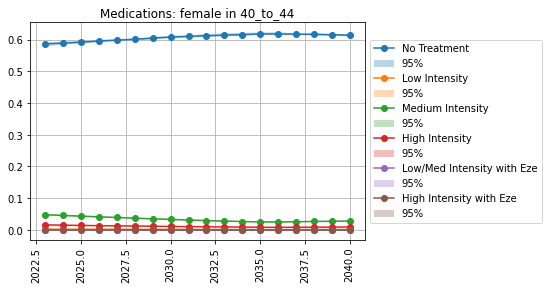

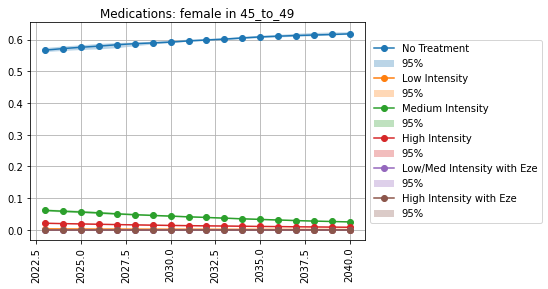

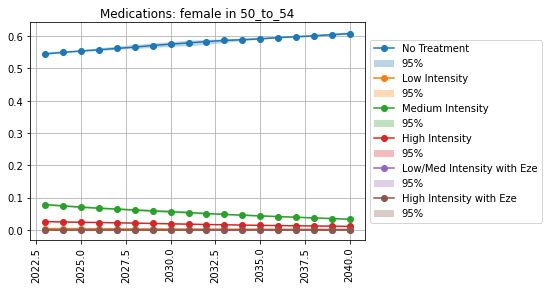

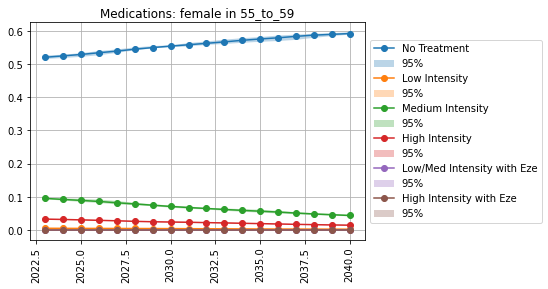

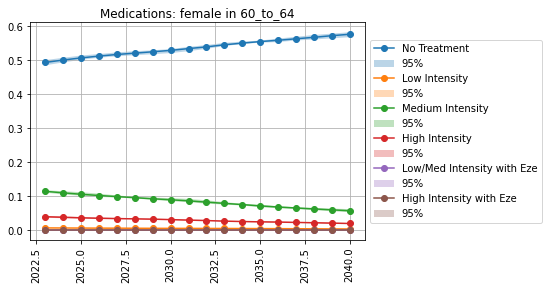

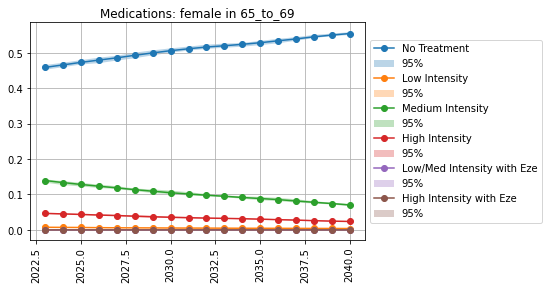

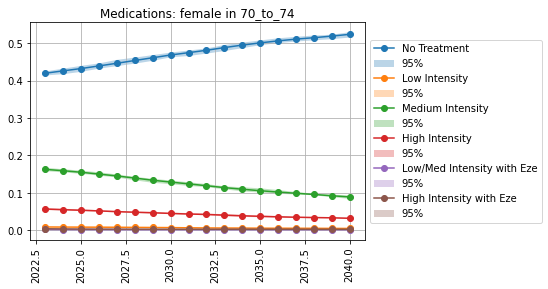

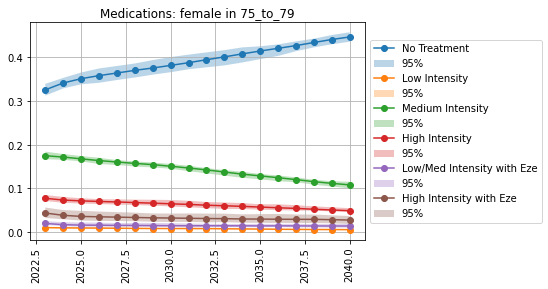

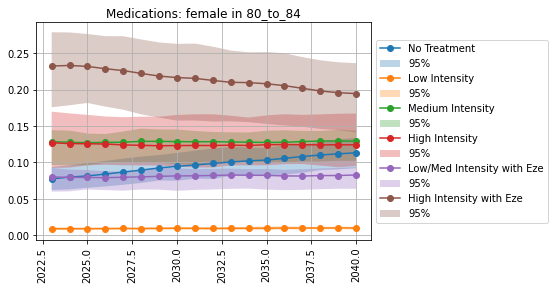

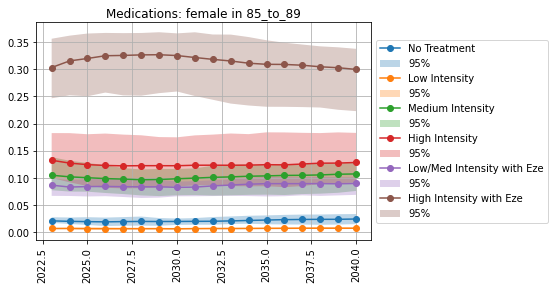

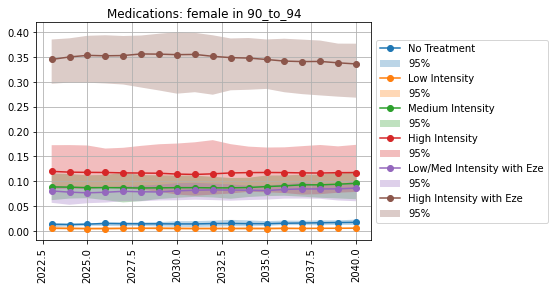

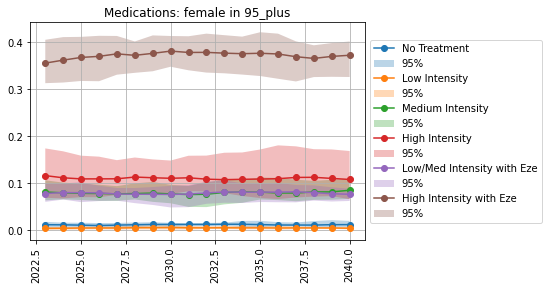

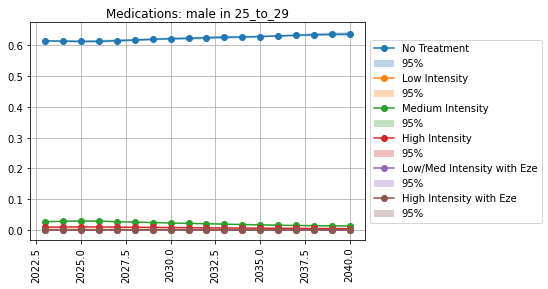

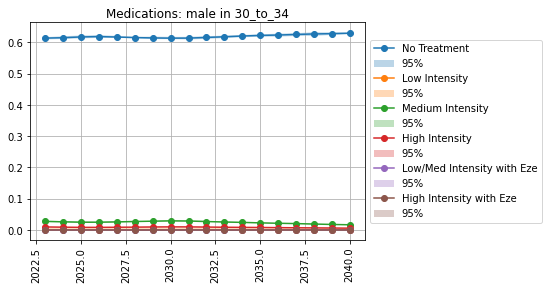

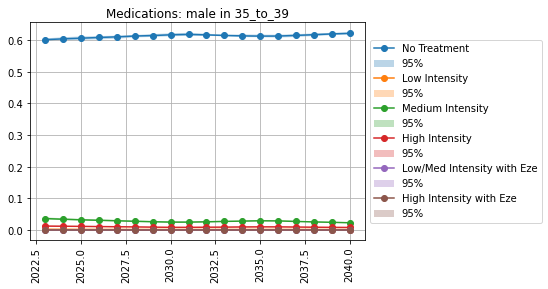

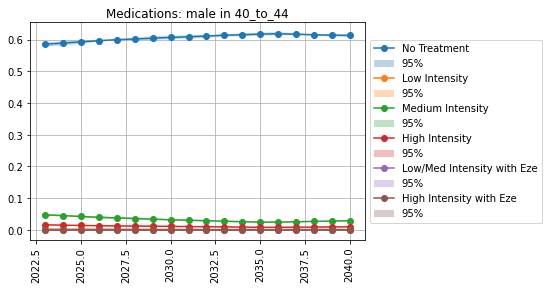

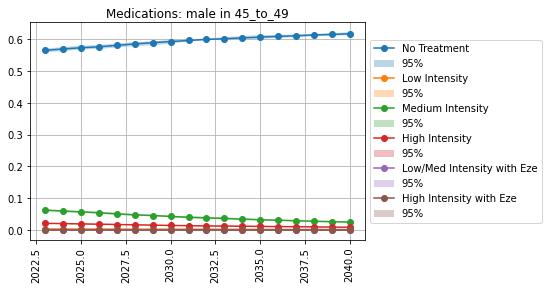

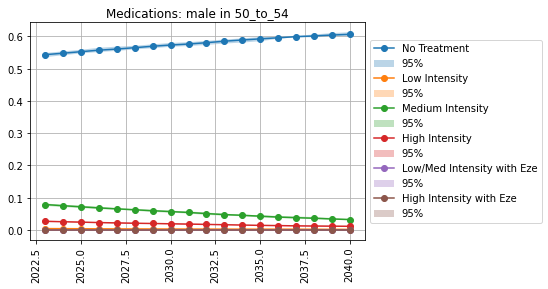

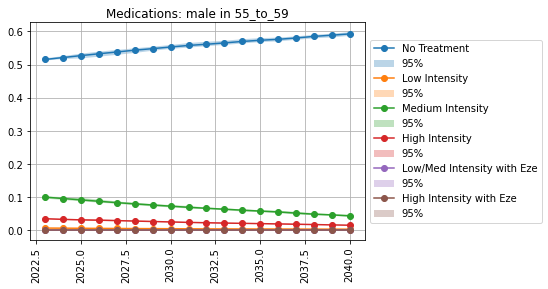

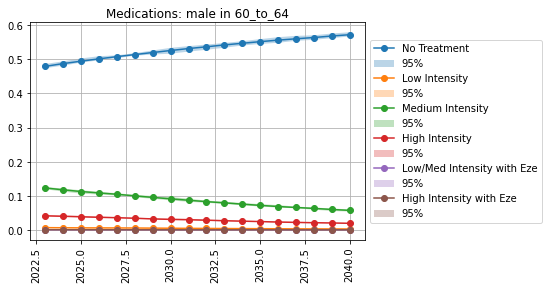

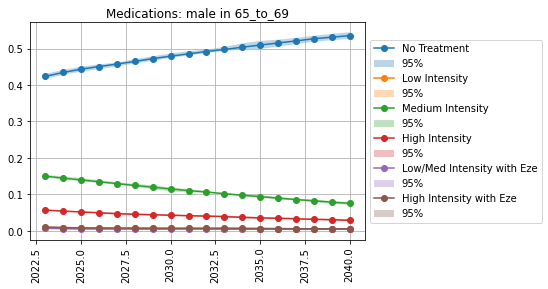

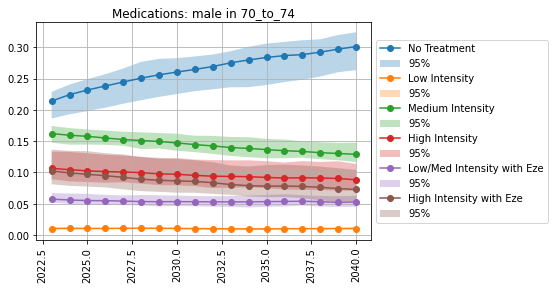

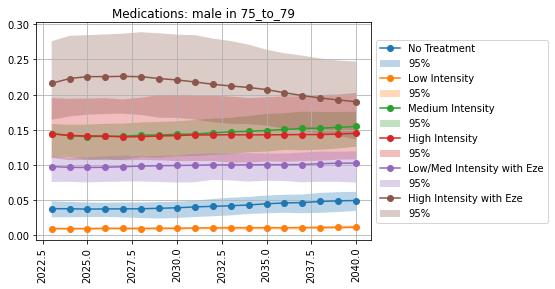

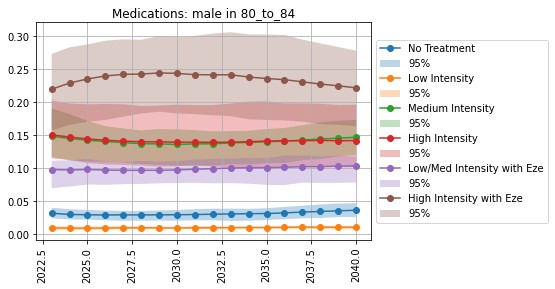

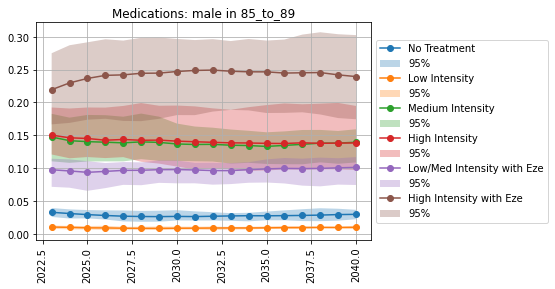

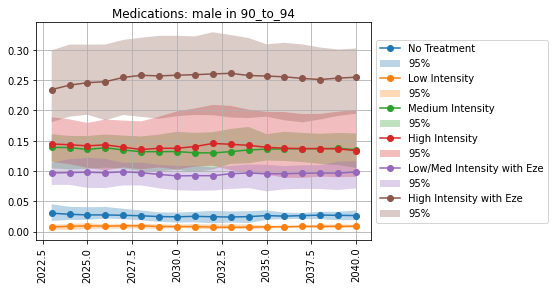

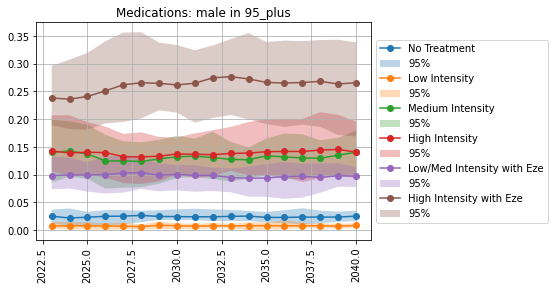

In [101]:
#%%capture
for sex in meds_adherent_rate_summ.sex.unique():
    for age in meds_adherent_rate_summ.age.unique():
        plt.figure() 
        no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='no_treatment')]
        plt.plot(no_trt['year'], no_trt['mean'], marker='o')
        plt.fill_between(no_trt['year'], no_trt['2.5%'], no_trt['97.5%'], alpha=.3)
        one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='low_intensity')]
        plt.plot(one_half['year'], one_half['mean'], marker='o')
        plt.fill_between(one_half['year'], one_half['2.5%'], one_half['97.5%'], alpha=.3)
        one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='medium_intensity')]
        plt.plot(one_std['year'], one_std['mean'], marker='o')
        plt.fill_between(one_std['year'], one_std['2.5%'], one_std['97.5%'], alpha=.3)
        two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='high_intensity')]
        plt.plot(two_half['year'], two_half['mean'], marker='o')
        plt.fill_between(two_half['year'], two_half['2.5%'], two_half['97.5%'], alpha=.3)
        two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='low_med_with_eze')]
        plt.plot(two_std['year'], two_std['mean'], marker='o')
        plt.fill_between(two_std['year'], two_std['2.5%'], two_std['97.5%'], alpha=.3)
        three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='high_with_eze')]
        plt.plot(three_half['year'], three_half['mean'], marker='o')
        plt.fill_between(three_half['year'], three_half['2.5%'], three_half['97.5%'], alpha=.3)
        plt.title(f'Medications: {sex} in {age}') 
        plt.xticks(rotation=90)
        plt.legend(['No Treatment', '95%', 'Low Intensity', '95%', 'Medium Intensity','95%','High Intensity', '95%','Low/Med Intensity with Eze', '95%','High Intensity with Eze', '95%'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()